In [1]:
import os
import re
import json
import nltk
import pickle
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import community

import networkx as nx

import config
from text_helpers import init_collection, add_col_values, \
    add_wordcloud_string, disp_wordcloud

In [2]:
# Download and import "book"
nltk.download('book', quiet=True)
from nltk import book

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [3]:
# read in character DataFrame
df = pd.read_csv(config.PATH_RES + 'df_chars.csv')
df.head()

# load graph
Gcc = nx.read_gexf(config.PATH_RES + 'Gcc_wow.gexf').to_undirected()

# NLTK on Cleaned Wikipages

In [4]:
# create NLTK text of cleaned texts
file_list = [fn for fn in glob(config.PATH_CLEAN + '*.txt')]
text_corpus = nltk.corpus.PlaintextCorpusReader('', file_list)
wiki_text = nltk.Text(text_corpus.words())

# create NLTK text of words
file_list = [fn for fn in glob(config.PATH_WORDS + '*.txt')]
words_corpus = nltk.corpus.PlaintextCorpusReader('', file_list)
wiki_words = nltk.Text(words_corpus.words())

In [5]:
# define what to look into
attr_lookup = {
    'Gender': [('Male', '#0B1C51'), ('Female', '#FCB9B2')],
    'Faction': [('Alliance', config.COLOR_ALLIANCE), ('Horde', config.COLOR_HORDE)]
}

## Community Stuff
Load processed communities. And name them according to most connected characters.

In [7]:
# load communities
communities = pickle.load(open(config.PATH_RES + 'Communities.json', 'rb'))

# get top chars in each community
degs = list(Gcc.degree())
com_names = []
for com in communities:
    com_sorted = sorted([(n, v) for n, v in degs if n in com], key=lambda x: x[1], reverse=True)
    top_names = [n for n, _ in com_sorted[:3]]
    com_name = ', '.join(top_names)
    com_names.append(com_name)

## Top Words
Inspect top 5 words according to tf-idf for each attribute split and for the different communities by Louvain.

In [8]:
# display top words for attributes
for attr in attr_lookup:
    print(f'\nTop 5 for attribute {attr}')
    with open(config.PATH_RES + attr + '_dict.json', 'rb') as f:
        col = pickle.load(f)
    col = add_wordcloud_string(col)
    for split, _ in attr_lookup[attr]:
        words = col[split]['words']
        tfidf = col[split]['tf'] * col[split]['idf']
        top_5 = ', '.join(words[np.argsort(tfidf)[::-1]][:5])
        print(f'\t{split}: {top_5}')


Top 5 for attribute Gender
	Male: horde, would, king, one, alliance
	Female: would, sylvanas, horde, jaina, alliance

Top 5 for attribute Faction
	Alliance: alliance, anduin, horde, would, jaina
	Horde: horde, thrall, would, lorthemar, baine


In [9]:
# display top words per community
print(f'Top 5 words for each community')
with open(config.PATH_RES + 'Louvain_dict.json', 'rb') as f:
    col = pickle.load(f)
col = add_wordcloud_string(col)

for i, com_name in enumerate(com_names):
    print(f'\n"{com_name}"')
    words = col[i]['words']
    tfidf = col[i]['tf'] * col[i]['idf']
    top_5 = ', '.join(words[np.argsort(tfidf)[::-1]][:5])
    print(top_5)

Top 5 words for each community

"Thrall, Khadgar, Velen"
li, would, chen, one, king

"Deathwing, Alexstrasza, Kalecgos"
dragon, deathwing, aspect, would, alexstrasza

"Tyrande Whisperwind, Illidan Stormrage, Sargeras"
malfurion, tyrande, illidan, night, elf

"Lor'themar Theron, Kael'thas Sunstrider, Alleria Windrunner"
horde, sylvanas, alliance, would, anduin

"Mayla Highmountain, Ebyssian, Lasan Skyhorn"
thrall, horde, would, orcs, guldan

"Jaina Proudmoore, Sylvanas Windrunner, Lich King"
king, arthas, lich, varian, alliance

"Garrosh Hellscream, Magni Bronzebeard, N'Zoth"
turalyon, alleria, light, would, danath


## Word Clouds
Create wordclouds of different attributes and for each community based on computed tf-idf values stored in `store/*_dict.json`.

In [10]:
# create wordclouds for attributes
for attr in attr_lookup:
    with open(config.PATH_RES + attr + '_dict.json', 'rb') as f:
        col = pickle.load(f)
    col = add_wordcloud_string(col)
    for split, color in attr_lookup[attr]:
        filename = config.PATH_PLOTS + f'wc_{split}.png'
        maskpath = f'./data/masks/{split}.jpg'
        if not os.path.isfile(maskpath):
            maskpath = ''
        disp_wordcloud(
            split, col,
            savepath=filename, 
            maskpath=maskpath, 
            contour_color=color,
            contour_width=4
        )

In [11]:
# create wordclouds for communities
with open(config.PATH_RES + 'Louvain_dict.json', 'rb') as f:
    col = pickle.load(f)
col = add_wordcloud_string(col)
for i, com_name in enumerate(com_names):
    filename = config.PATH_PLOTS + f'wc_com_{i}.png'
    disp_wordcloud(
        i, col,
        title = com_name,
        savepath=filename,
        contour_color=color,
        contour_width=4
    )

## leftovers

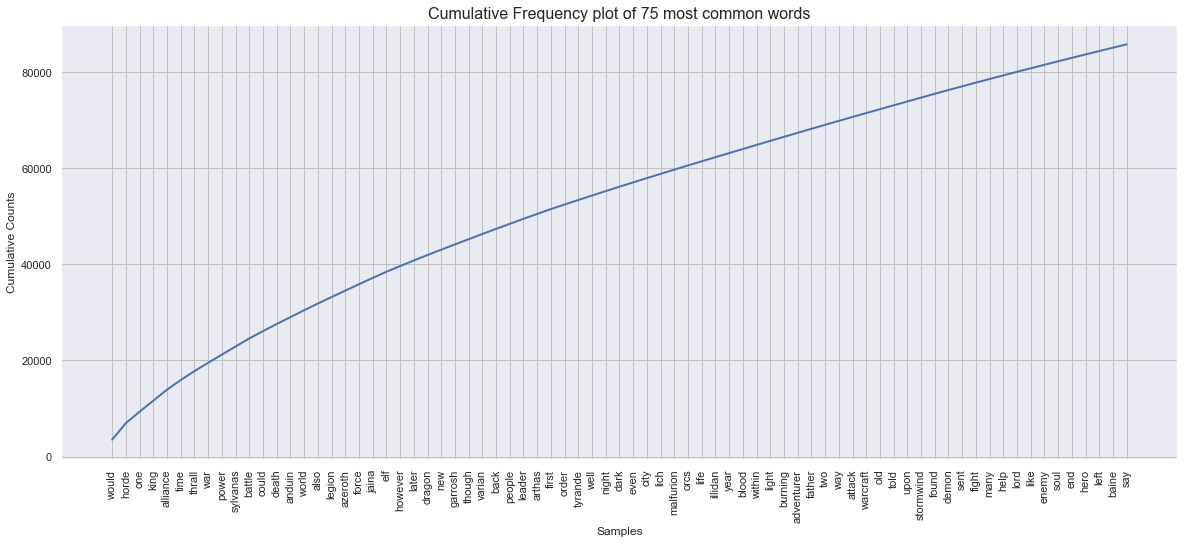

In [13]:
# Get the frequency distribution of the text
fd = book.FreqDist(wiki_words)

# Display the 75 most common tokens in a cumulative frequency plot
plt.figure(figsize=(20, 8))
plt.title('Cumulative Frequency plot of 75 most common words', fontsize=16)
fd.plot(75, cumulative=True)
plt.show()

# NLTK on WoWhead User Comments

# Test shit